In [1]:
import numpy as np
import os
import h5py
import random
import matplotlib.pyplot as plt

In [2]:
# Directory containing .h5 files
directory = r"Data\BraTS2020_training_data\content\data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    selected_file = random.choice(h5_files)
    file_path = os.path.join(directory, selected_file)
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 0.0
Array min val: 0.0

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 0
Array min val: 0


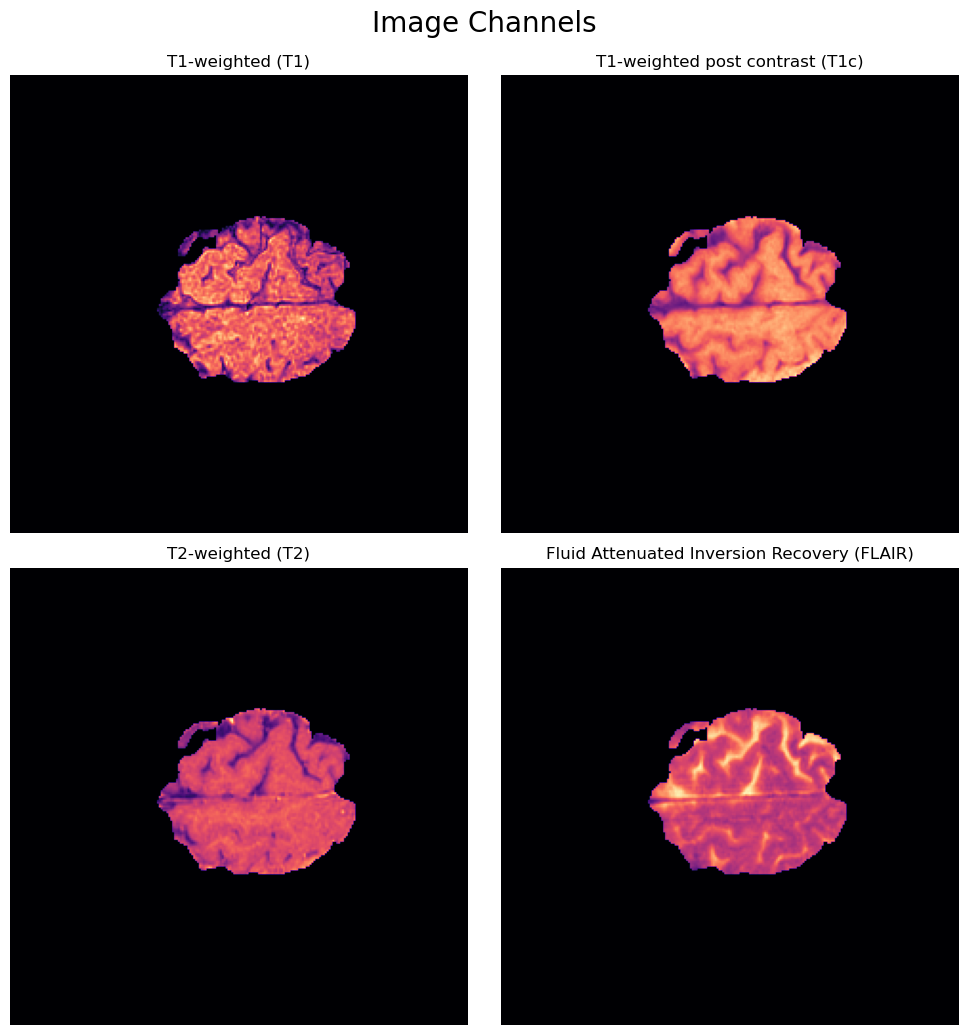

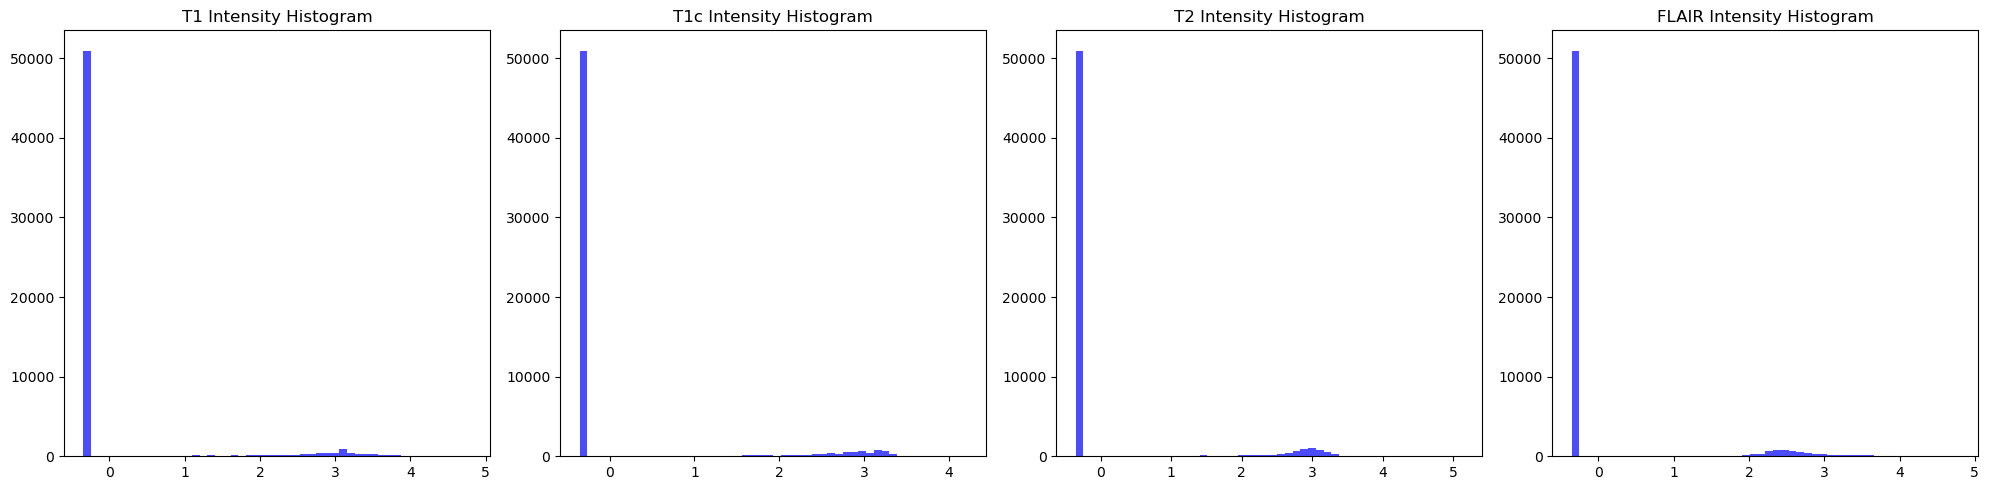

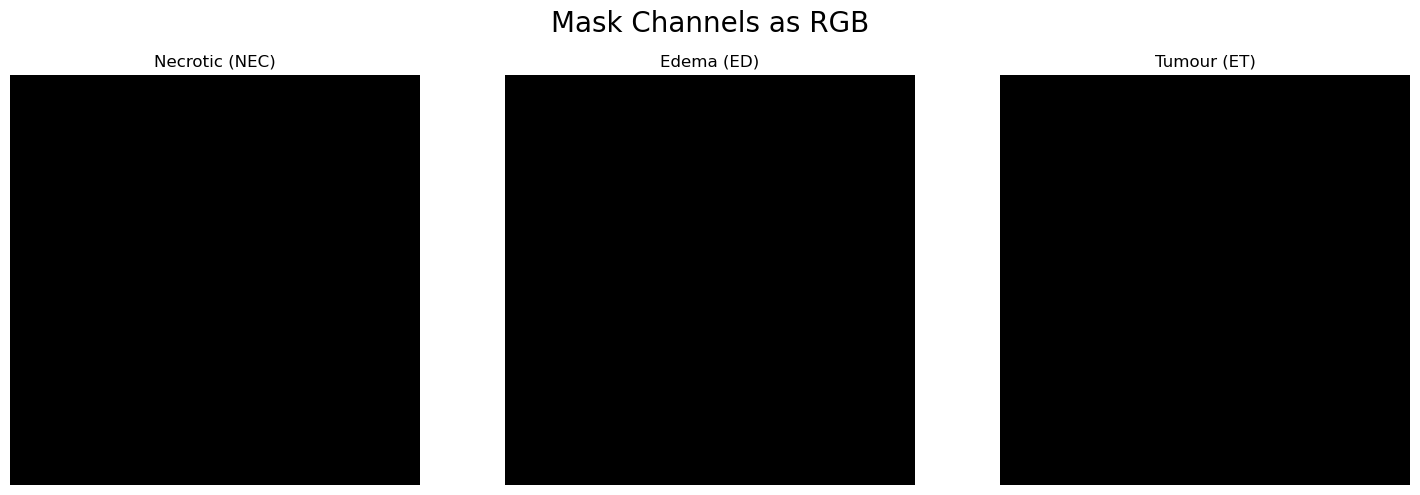

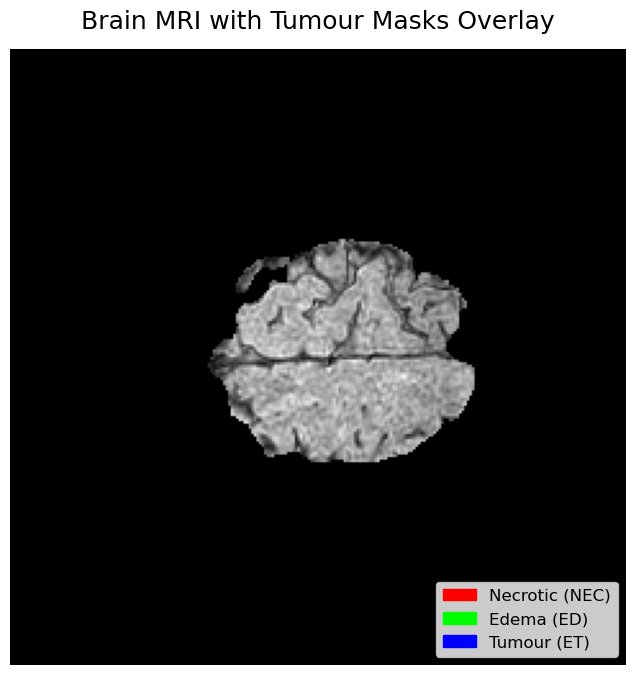

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import random
import matplotlib.patches as mpatches

def normalize_image(image):
    return (image - image.min()) / (image.max() - image.min())

def display_image_channels(image, title='Image Channels'):
    channel_names = [
        'T1-weighted (T1)', 
        'T1-weighted post contrast (T1c)', 
        'T2-weighted (T2)', 
        'Fluid Attenuated Inversion Recovery (FLAIR)'
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]
        ax.imshow(channel_image, cmap='magma')    
        ax.axis('off')
        ax.set_title(channel_names[idx])
    
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()


def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    colors = ['red', 'green', 'blue']
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = (mask[idx, :, :] * 255).astype(np.uint8)
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)  # Adjust top spacing to prevent title overlap
    plt.suptitle(title, fontsize=20)
    plt.show()

def overlay_masks_on_image(image, mask, alpha=0.4, title='Brain MRI with Tumour Masks Overlay'):
    t1_image_normalized = normalize_image(image[0, :, :])
    
    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    mask_colors = np.array([[1, 0, 0],  # Red for Necrotic (NEC)
                             [0, 1, 0],  # Green for Edema (ED)
                             [0, 0, 1]]) # Blue for Tumour (ET)
    
    for i in range(3):
        mask_layer = mask[i, :, :]
        rgb_image = np.where(mask_layer[:, :, None], alpha * mask_colors[i] + (1 - alpha) * rgb_image, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    
    legend_patches = [mpatches.Patch(color=mask_colors[i], label=['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)'][i]) for i in range(3)]
    plt.legend(handles=legend_patches, loc='lower right', fontsize=12)  # Adjusted position to prevent overlap
    
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()

def plot_intensity_histogram(image):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    channel_names = ['T1', 'T1c', 'T2', 'FLAIR']
    
    for i, ax in enumerate(axes):
        ax.hist(image[i, :, :].flatten(), bins=50, color='blue', alpha=0.7)
        ax.set_title(f'{channel_names[i]} Intensity Histogram')
    
    plt.tight_layout()
    plt.show()

# Sample image to view
sample_selected = random.choice(h5_files)
sample_file_path = os.path.join(directory, sample_selected)

data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

display_image_channels(image)
plot_intensity_histogram(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

In [4]:
import os
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        """
        Custom PyTorch dataset for loading brain scan images and masks from HDF5 files.
        
        Parameters:
        - file_paths (list): List of file paths to HDF5 files.
        - deterministic (bool): If True, ensures reproducibility by setting a fixed seed.
        """
        self.file_paths = file_paths
        
        if deterministic:
            np.random.seed(1)  # Ensures reproducibility
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        """
        Loads an image and corresponding mask from an HDF5 file and preprocesses them.
        
        Returns:
        - image (torch.Tensor): Normalized image tensor of shape (C, H, W).
        - mask (torch.Tensor): Mask tensor of shape (C, H, W).
        """
        file_path = self.file_paths[idx]
        
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape from (H, W, C) to (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            
            # Normalize each channel of the image between 0 and 1
            for i in range(image.shape[0]):
                min_val = np.min(image[i])
                max_val = np.max(image[i]) + 1e-4  # Avoid division by zero
                image[i] = (image[i] - min_val) / max_val
            
            # Convert to PyTorch tensors
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)
            
        return image, mask

# Gather all HDF5 file paths from the directory
directory = "Data\BraTS2020_training_data\content\data"  # Replace with actual directory path
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]

# Shuffle dataset for randomness
np.random.seed(42)
np.random.shuffle(h5_files)

# Split dataset into training (80%) and validation (20%) sets
split_idx = int(0.8 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create dataset instances
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Create DataLoaders for batch processing
train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=5, shuffle=False)

# Create a test input iterator for visualization
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=True))

# Verify that the DataLoaders work by printing batch shapes
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])
Validation batch - Images shape: torch.Size([5, 4, 240, 240]) Masks shape: torch.Size([5, 3, 240, 240])


In [5]:
from torch import nn

def encoder_block(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates an encoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Encoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

def decoder_block(in_channels, out_channels, activation=nn.ReLU()):
    """
    Creates a decoder block with two convolutional layers followed by activation.
    
    Parameters:
    - in_channels (int): Number of input channels.
    - out_channels (int): Number of output channels.
    - activation (nn.Module): Activation function.
    
    Returns:
    - nn.Sequential: Decoder block.
    """
    return nn.Sequential(
        nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        activation,
        nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, stride=1, padding=1),
        activation
    )

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=3, n_filters=32, activation=nn.ReLU()):
        """
        Initializes the U-Net model.
        
        Parameters:
        - in_channels (int): Number of input channels.
        - out_channels (int): Number of output channels.
        - n_filters (int): Base number of filters.
        - activation (nn.Module): Activation function.
        """
        super(UNet, self).__init__()
        
        # Downsampling method
        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Upsampling method
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Encoder
        self.enc1 = encoder_block(in_channels, 1 * n_filters, activation)
        self.enc2 = encoder_block(1 * n_filters, 2 * n_filters, activation)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(2 * n_filters, 4 * n_filters, kernel_size=3, stride=1, padding=1),
            activation,
            nn.Conv2d(4 * n_filters, 2 * n_filters, kernel_size=3, stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec2 = decoder_block(4 * n_filters, 1 * n_filters, activation)
        self.dec1 = decoder_block(2 * n_filters, 1 * n_filters, activation)
        
        # Output layer
        self.output = nn.Conv2d(1 * n_filters, out_channels, kernel_size=1, stride=1, padding=0)
        
    def forward(self, x):
        # Encoder pathway
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.downsample(enc1))
        
        # Bottleneck
        bottleneck = self.bottleneck(self.downsample(enc2))
        
        # Decoder pathway with skip connections
        dec2 = self.dec2(torch.cat([self.upsample(bottleneck), enc2], dim=1))
        dec1 = self.dec1(torch.cat([self.upsample(dec2), enc1], dim=1))
        
        # Output layer
        out = self.output(dec1)
        return out

In [7]:
def count_parameters(model):
    """
    Counts and prints the number of trainable parameters in the model.
    
    Parameters:
    - model (nn.Module): The neural network model.
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total Parameters: {total_params:,}\n')

def save_model(model, path='model_weights.pth'):
    """
    Saves the model's state dictionary to the specified path.
    
    Parameters:
    - model (nn.Module): The neural network model.
    - path (str): File path to save the model weights.
    """
    torch.save(model.state_dict(), path)

In [8]:
train_config = {
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          50,
    'batch_size':        64,
    'learning_rate':     0.001,
    'batches_per_epoch': 64,
    'lr_decay_factor':   1
}

# Instantiate the model
activation_function = nn.LeakyReLU(negative_slope=0.1)  #using leaky relu in place of relu
model = UNet(in_channels=4, out_channels=3, n_filters=32, activation=activation_function)

# Count parameters
count_parameters(model)

# Move model to device
device = torch.device(train_config['device'])
model = model.to(device)

Total Parameters: 333,571



In [9]:
def dice_coefficient(preds, targets, smooth=1e-6):
    """
    Computes the Dice coefficient between predictions and targets.
    
    Args:
    - preds (torch.Tensor): The predicted output from the model (logits).
    - targets (torch.Tensor): The ground truth binary masks.
    - smooth (float): Smoothing factor to avoid division by zero.
    
    Returns:
    - dice (float): The Dice coefficient for the batch.
    """
    # Apply sigmoid to the predicted logits
    preds = torch.sigmoid(preds)
    
    # Threshold to get binary predictions (0 or 1)
    preds = (preds > 0.5).float()
    
    # Flatten tensors to 1D for all the pixels in the batch
    preds = preds.view(-1)
    targets = targets.view(-1)
    
    # Compute the intersection and union
    intersection = (preds * targets).sum()
    dice = (2.0 * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    
    return dice.item()

In [10]:
def calculate_precision(preds, targets, smooth=1e-6):
    """
    Computes precision between predictions and targets.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    predicted_positives = preds.sum()

    precision_value = (true_positives + smooth) / (predicted_positives + smooth)
    return precision_value.item()

In [11]:
def calculate_recall(preds, targets, smooth=1e-6):
    """
    Computes recall between predictions and targets.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    true_positives = (preds * targets).sum()
    actual_positives = targets.sum()

    recall_value = (true_positives + smooth) / (actual_positives + smooth)
    return recall_value.item()

In [12]:
def calculate_accuracy(preds, targets):
    """
    Computes accuracy between predictions and targets.
    """
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()
    preds = preds.view(-1)
    targets = targets.view(-1)

    correct = (preds == targets).float().sum()
    total = targets.numel()

    accuracy_value = correct / total
    return accuracy_value.item()

In [13]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001):
        """
        Initializes early stopping mechanism.
        
        Parameters:
        - patience (int): Number of epochs to wait before stopping if no improvement.
        - delta (float): Minimum change in the monitored metric to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = float('inf')
        self.counter = 0
        self.early_stop = False
    
    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [14]:
def validate_model(model, val_dataloader, loss_fn, device, early_stopping=None):
    """
    Validates the model on the validation dataset and calculates performance metrics.
    
    Parameters:
    - model (torch.nn.Module): The model to validate.
    - val_dataloader (torch.utils.data.DataLoader): Dataloader for validation data.
    - loss_fn (torch.nn.Module): Loss function used for validation.
    - device (str): The device to run the validation on ('cpu' or 'cuda').
    - early_stopping (EarlyStopping, optional): Instance of EarlyStopping class.

    Returns:
    - val_loss (float): Average validation loss for the epoch.
    - dice (float): Average Dice coefficient for the epoch.
    - precision (float): Average precision for the epoch.
    - recall (float): Average recall for the epoch.
    - accuracy (float): Average accuracy for the epoch.
    - early_stop (bool): Whether early stopping was triggered.
    """
    model.eval()
    val_loss = 0.0
    dice_total = 0.0
    precision_total = 0.0
    recall_total = 0.0
    accuracy_total = 0.0
    n_batches = len(val_dataloader)
    
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs = val_inputs.to(device)
            val_targets = val_targets.to(device)
            
            val_preds = model(val_inputs)
            loss = loss_fn(val_preds, val_targets)
            val_loss += loss.item()
            
            dice_total += dice_coefficient(val_preds, val_targets)
            precision_total += calculate_precision(val_preds, val_targets)
            recall_total += calculate_recall(val_preds, val_targets)
            accuracy_total += calculate_accuracy(val_preds, val_targets)
    
    val_loss /= n_batches
    dice_total /= n_batches
    precision_total /= n_batches
    recall_total /= n_batches
    accuracy_total /= n_batches
    
    if early_stopping:
        early_stopping(val_loss)
    
    return val_loss, dice_total, precision_total, recall_total, accuracy_total, early_stopping.early_stop if early_stopping else False

In [15]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']
    patience = config.get('patience', 5)

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss()
    early_stopping = EarlyStopping(patience=patience)

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        total_dice, total_precision, total_recall, total_accuracy = 0, 0, 0, 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: 
                print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            
            # Forward pass
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            # Calculate metrics
            dice_score = dice_coefficient(train_preds, train_targets)
            precision = calculate_precision(train_preds, train_targets)
            recall = calculate_recall(train_preds, train_targets)
            accuracy = calculate_accuracy(train_preds, train_targets)

            total_dice += dice_score
            total_precision += precision
            total_recall += recall
            total_accuracy += accuracy

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break

        # Average metrics for the epoch
        avg_train_loss = train_epoch_loss / batches_per_epoch
        avg_dice = total_dice / batches_per_epoch
        avg_precision = total_precision / batches_per_epoch
        avg_recall = total_recall / batches_per_epoch
        avg_accuracy = total_accuracy / batches_per_epoch

        print(f"\nEpoch {epoch}/{n_epochs}:")
        print(f"Training Loss: {avg_train_loss:.4f}, Dice: {avg_dice:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, Accuracy: {avg_accuracy:.4f}")

        train_epoch_losses.append(avg_train_loss)

        # Validation step
        avg_val_loss, avg_val_dice, avg_val_precision, avg_val_recall, avg_val_accuracy, early_stop = validate_model(model, val_dataloader, loss_fn, device)
        print(f"Validation Loss: {avg_val_loss:.4f}, Dice: {avg_val_dice:.4f}, Precision: {avg_val_precision:.4f}, Recall: {avg_val_recall:.4f}, Accuracy: {avg_val_accuracy:.4f}")
        val_epoch_losses.append(avg_val_loss)

        if early_stop:
            print("Early stopping triggered. Stopping training.")
            break

    return train_epoch_losses, val_epoch_losses


In [16]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=True)

Training...
Train batch: 42/64, Avg batch loss: 0.139445

KeyboardInterrupt: 

In [ ]:
def plot_learning_curves(train_epoch_losses, val_epoch_losses):
    plt.style.use('ggplot')
    plt.rcParams['text.color'] = '#333333'

    fig, axis = plt.subplots(1, 1, figsize=(10, 6))

    # Plot training and validation loss (NaN is used to offset epochs by 1)
    axis.plot([np.NaN] + train_epoch_losses, color='#636EFA', marker='o', linestyle='-', linewidth=2, markersize=5, label='Training Loss')
    axis.plot([np.NaN] + val_epoch_losses,   color='#EFA363', marker='s', linestyle='-', linewidth=2, markersize=5, label='Validation Loss')

    # Adding title, labels and formatting
    axis.set_title('Training and Validation Loss Over Epochs', fontsize=16)
    axis.set_xlabel('Epoch', fontsize=14)
    axis.set_ylabel('Loss', fontsize=14)

    axis.set_ylim(0, 1)
    
    axis.legend(fontsize=12)
    axis.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
plot_learning_curves(train_epoch_losses, val_epoch_losses)

In [ ]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model, test_input, test_target, device)